<a href="https://colab.research.google.com/github/imRitam10/emotionDetectionUsingNLP/blob/main/emotiondetectionusingnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Information

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import mlxtend
import sklearn.cluster as cluster
import sklearn.neighbors
import sklearn.metrics as metrics
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, precision_recall_curve
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ayushgupta/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayushgupta/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load and explore the data
#### The data is available at this source, and you can learn more about how and why this dataset is created from this paper.
Data source: https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp 

In [4]:
train_data = pd.read_csv('train.txt',names=['sentence','emotion'],header=None, sep=';')
test_data = pd.read_csv('test.txt',names=['sentence','emotion'],header=None, sep=';')
val_data= pd.read_csv('val.txt',names=['sentence','emotion'],header=None, sep=';')
df = pd.concat([train_data,test_data, val_data])
print('Total data:',df.shape)

Total data: (20000, 2)


In [5]:
# Null Check
train_data.isnull().sum()
test_data.isnull().sum()
val_data.isnull().sum()

sentence    0
emotion     0
dtype: int64

In [6]:
df = df.drop_duplicates(keep="first") # Drop duplicated data and reindex the data
df_reidx = df.reset_index(drop=True)
df_reidx.shape

(19999, 2)

In [7]:
# convert the emotions to binary labels. love and joy emotions are "not-stressed ==1", and sadness, anger, fear, and surprise are "stressed == 0".
df_reidx['label']=df_reidx['emotion'].replace({'joy': "not-stressed" , 'love': "not-stressed",'surprise': "medium-stressed" ,
                                   'sadness': "stressed", 'anger': "stressed", 'fear': "stressed"})

In [8]:
# check if pos and neg sentiments
df_reidx.label.value_counts()

stressed           10879
not-stressed        8401
medium-stressed      719
Name: label, dtype: int64

In [9]:
df_reidx['length'] = df_reidx['sentence'].apply(len) # number of characters
df_reidx['length'].describe() # info()

count    19999.000000
mean        96.671784
std         55.778779
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: length, dtype: float64

In [10]:
df_reidx.tail()

,sentence,emotion,label,length
19994,im having ssa examination tomorrow in the morn...,sadness,stressed,191
19995,i constantly worry about their fight against n...,joy,not-stressed,173
19996,i feel its important to share this info for th...,joy,not-stressed,80
19997,i truly feel that if you are passionate enough...,joy,not-stressed,105
19998,i feel like i just wanna buy any cute make up ...,joy,not-stressed,74


# Text Preprocessing
#### To clean the sentences,we do text preprocessing.

*   Decontracted
*   Data cleaning
Additionally,
*   Spell check
*   Lemmatization
*   Nomalization





In [11]:
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def decontracted(phrase):
    """
    We first define a function to expand the contracted phrase into normal words
    """
    # specific
    phrase = re.sub(r"wont", "will not", phrase)
    phrase = re.sub(r"wouldnt", "would not", phrase)
    phrase = re.sub(r"shouldnt", "should not", phrase)
    phrase = re.sub(r"couldnt", "could not", phrase)
    phrase = re.sub(r"cudnt", "could not", phrase)
    phrase = re.sub(r"cant", "can not", phrase)
    phrase = re.sub(r"dont", "do not", phrase)
    phrase = re.sub(r"doesnt", "does not", phrase)
    phrase = re.sub(r"didnt", "did not", phrase)
    phrase = re.sub(r"wasnt", "was not", phrase)
    phrase = re.sub(r"werent", "were not", phrase)
    phrase = re.sub(r"havent", "have not", phrase)
    phrase = re.sub(r"hadnt", "had not", phrase)

    # general
    phrase = re.sub(r"n\ t", " not", phrase)
    #phrase = re.sub(r"\re", " are", phrase)
    phrase = re.sub(r"\ s ", " is ", phrase) # prime 
    phrase = re.sub(r"\ d ", " would ", phrase)
    phrase = re.sub(r"\ ll ", " will ", phrase)
    phrase = re.sub(r"\dunno", "do not ", phrase)
    phrase = re.sub(r"ive ", "i have ", phrase)
    phrase = re.sub(r"im ", "i am ", phrase)
    phrase = re.sub(r"i m ", "i am ", phrase)
    phrase = re.sub(r" w ", " with ", phrase)
    
    return phrase

    
def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['sentence']):
        
        # expand the contracted words
        review_text = decontracted(review_text)
        #remove html tags
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #remove url 
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)
        
        #Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])
        
        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)
    
        cleaned_review.append(review_text)

    return cleaned_review  

df_reidx['cleaned_sentence'] = clean_text(df_reidx)
df_reidx.head()  

100%|██████████| 19999/19999 [00:03<00:00, 5123.98it/s]


,sentence,emotion,label,length,cleaned_sentence
0,i didnt feel humiliated,sadness,stressed,23,i did not feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,stressed,108,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong,anger,stressed,48,i am grabbing a minute to post i feel greedy w...
3,i am ever feeling nostalgic about the fireplac...,love,not-stressed,92,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy,anger,stressed,20,i am feeling grouchy


###### additional lemmatization

In [12]:
import nltk
nltk.download('punkt')
def remove_stopwords(phrase):
    remove_sw = []
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
    stop_words = stopwords.words('english')
    
    for review_text in tqdm(phrase):
        tokens = word_tokenize(review_text)
        tokens = [word for word in tokens if not word in stop_words]
        remove_sw.append(tokens)
    return remove_sw

df_reidx['cleaned_sentence'] = remove_stopwords(df_reidx['cleaned_sentence'])
df_reidx.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayushgupta/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
100%|██████████| 19999/19999 [00:02<00:00, 7671.37it/s]


,sentence,emotion,label,length,cleaned_sentence
0,i didnt feel humiliated,sadness,stressed,23,"[feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,sadness,stressed,108,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,anger,stressed,48,"[grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,love,not-stressed,92,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,anger,stressed,20,"[feeling, grouchy]"


In [13]:
#stemming for extract the actual meaning of the words
from nltk.stem import PorterStemmer

def stemming(phrase):
    stemmer = PorterStemmer()
    stem_output=[]
    stemmed=[]
    for review_text in tqdm(phrase):
        stemmed = [stemmer.stem(word) for word in review_text]
        stem_output.append(stemmed)
    return stem_output

df_reidx['cleaned_sentence'] = stemming(df_reidx['cleaned_sentence'])
df_reidx['cleaned_sentence'].head()

100%|██████████| 19999/19999 [00:03<00:00, 6349.87it/s]


0                                       [feel, humili]
1    [go, feel, hopeless, damn, hope, around, someo...
2             [grab, minut, post, feel, greedi, wrong]
3    [ever, feel, nostalg, fireplac, know, still, n...
4                                      [feel, grouchi]
Name: cleaned_sentence, dtype: object

In [14]:
def to_sentence(phrase):
    sentence=[]
    for words in tqdm(phrase):
        sentence.append((" ").join(words))
    return sentence
df_reidx['cleaned_sentence']=to_sentence(df_reidx['cleaned_sentence'])
df_reidx['cleaned_sentence'].head()

100%|██████████| 19999/19999 [00:00<00:00, 1508531.35it/s]


0                                          feel humili
1    go feel hopeless damn hope around someon care ...
2                    grab minut post feel greedi wrong
3    ever feel nostalg fireplac know still noth pro...
4                                         feel grouchi
Name: cleaned_sentence, dtype: object

# Feature Engineering

### CounterVectorize: tokenization: 

In [15]:
# convert the cleaned sentences to vectors
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
# a built-in stop word list for english is used
# all values of n such than min_n<=n<= max_n will be used. (1,1): only unigrams, (1,2):uni&bigram, (2,2): only bigrams
# max_df: when building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold.
# min_df: ignore terms that have a document frequency strictly lower than the given threshold.

vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=3, ngram_range=(1,1),tokenizer = token.tokenize)
x = vectorizer.fit_transform(df_reidx.cleaned_sentence)
y = df_reidx.label.values

print("X.shape : ",x.shape)
print("y.shape : ",y.shape)

X.shape :  (19999, 4374)
y.shape :  (19999,)


# Train Test split

```
# This is formatted as code
```



In [18]:
# do shuffle to make neg and pos data of data set split equaly in the test and training set
# do random_sate for making it settle when we run this code repeatedly
train_idx, test_idx = train_test_split(np.arange(df_reidx.shape[0]), test_size=0.2,shuffle=True, random_state=42)

x_train = x[train_idx]
y_train = y[train_idx]

x_test = x[test_idx]
y_test = y[test_idx]
print("Number of training examples:{}".format(len(train_idx)))
print("Number of testing examples:{}\n".format(len(test_idx)))
print("Training data: X_train : {}, y_train : {}".format(x_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(x_test.shape, y_test.shape))


Number of training examples:15999
Number of testing examples:4000

Training data: X_train : (15999, 4374), y_train : (15999,)
Testing data: X_test : (4000, 4374), y_test : (4000,)


In [19]:
x_train.shape

(15999, 4374)

# Model Training

#### Logistic Regression

                 precision    recall  f1-score   support

medium-stressed       0.69      0.72      0.70       153
   not-stressed       0.94      0.94      0.94      1662
       stressed       0.94      0.95      0.94      2185

       accuracy                           0.93      4000
      macro avg       0.86      0.87      0.86      4000
   weighted avg       0.93      0.93      0.93      4000


Accuracy for Logistic Regression model: 0.93225




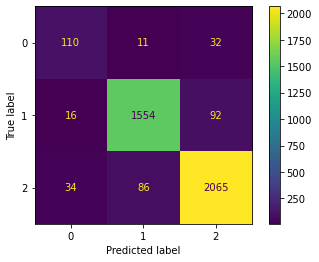

In [20]:
# fit a logistic regression classifier on the training data use default settings
lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train)

# make prediction on testing data
y_pred_test_lr = lr_clf.predict(x_test)
y_predprob_lr = lr_clf.predict_proba(x_test)
matrix_lr = confusion_matrix(y_test,y_pred_test_lr)
print(classification_report(y_test, y_pred_test_lr))
print("\nAccuracy for Logistic Regression model:",metrics.accuracy_score(y_test, y_pred_test_lr))
print("\n")
y_predict = lr_clf.predict(x_test)
matrix_display = ConfusionMatrixDisplay(matrix_lr).plot()

#### Naive Bayes classifier

##### BernouliNB

A binary algorithm used when the feature is present or not.

                 precision    recall  f1-score   support

medium-stressed       0.17      0.10      0.12       153
   not-stressed       0.90      0.89      0.90      1662
       stressed       0.89      0.93      0.91      2185

       accuracy                           0.88      4000
      macro avg       0.65      0.64      0.64      4000
   weighted avg       0.87      0.88      0.87      4000


Accuracy for Bernouli Naive Bayes model: 0.88125




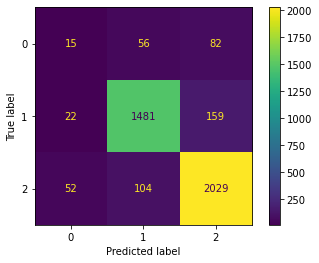

In [21]:
from sklearn.naive_bayes import BernoulliNB
nb_clf = BernoulliNB()
nb_clf.fit(x_train, y_train)
# make prediction on testing data
y_pred_test_nb = nb_clf.predict(x_test)
y_predprob_nb = nb_clf.predict_proba(x_test)
matrix_nb = confusion_matrix(y_test,y_pred_test_nb)
print(classification_report(y_test, y_pred_test_nb))
print("\nAccuracy for Bernouli Naive Bayes model:",metrics.accuracy_score(y_test, y_pred_test_nb))
print("\n")
matrix_display = ConfusionMatrixDisplay(matrix_nb).plot()

##### MultinominaliNB

It consider a feature vector where a given term represents the number of times it appears or very ofen, such as frequency.

                 precision    recall  f1-score   support

medium-stressed       0.57      0.34      0.42       153
   not-stressed       0.91      0.90      0.91      1662
       stressed       0.91      0.94      0.92      2185

       accuracy                           0.90      4000
      macro avg       0.79      0.73      0.75      4000
   weighted avg       0.90      0.90      0.90      4000


Accuracy for multinominal Naive Bayes model: 0.90175




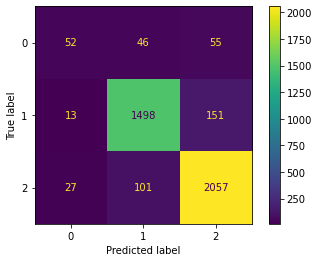

In [22]:
mnb = MultinomialNB()
mnb.fit(x_train, y_train)
# make prediction on testing data
y_pred_test_mnb = mnb.predict(x_test)
y_predprob_mnb = mnb.predict_proba(x_test)
matrix = confusion_matrix(y_test,y_pred_test_mnb)
print(classification_report(y_test, y_pred_test_mnb))
print("\nAccuracy for multinominal Naive Bayes model:",metrics.accuracy_score(y_test, y_pred_test_mnb))
print("\n")

y_predict = mnb.predict(x_test)
cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()

# Cross validataion

In [23]:
acc_score_lr = metrics.accuracy_score(y_pred_test_lr,y_test)
prec_score_lr = precision_score(y_test,y_pred_test_lr, average='macro')
recall_lr = recall_score(y_test, y_pred_test_lr,average='macro')
f1_lr = f1_score(y_test,y_pred_test_nb,average='macro')
matrix_lr = confusion_matrix(y_test,y_pred_test_lr)
print('Logistic Regression Model\n')
print(str('Accuracy: '+'{:04.2f}'.format(acc_score_lr*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score_lr*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall_lr*100))+'%')
print('F1 Score: ',f1_lr)
print(matrix_lr)

Logistic Regression Model

Accuracy: 93.23%
Precision: 85.74%
Recall: 86.64%
F1 Score:  0.6438713690358201
[[ 110   11   32]
 [  16 1554   92]
 [  34   86 2065]]


##### BernouliNB

In [24]:
acc_score_nb = metrics.accuracy_score(y_pred_test_nb,y_test)
prec_score_nb = precision_score(y_test,y_pred_test_nb, average='macro')
recall_nb = recall_score(y_test, y_pred_test_nb,average='macro')
f1_nb = f1_score(y_test,y_pred_test_nb,average='macro')
matrix_nb = confusion_matrix(y_test,y_pred_test_nb)
print('Bernouli Naive Bayes Model\n')
print(str('Accuracy: '+'{:04.2f}'.format(acc_score_nb*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score_nb*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall_nb*100))+'%')
print('F1 Score: ',f1_nb)
print(matrix_nb)

Bernouli Naive Bayes Model

Accuracy: 88.12%
Precision: 65.50%
Recall: 63.92%
F1 Score:  0.6438713690358201
[[  15   56   82]
 [  22 1481  159]
 [  52  104 2029]]


##### MultinominaliNB

In [25]:
acc_score_mnb = metrics.accuracy_score(y_pred_test_mnb,y_test)
prec_score_mnb = precision_score(y_test,y_pred_test_mnb, average='macro')
recall_mnb = recall_score(y_test, y_pred_test_mnb,average='macro')
f1_mnb = f1_score(y_test,y_pred_test_mnb,average='macro')
matrix_mnb = confusion_matrix(y_test,y_pred_test_mnb)
print('Multimominal Naive Bayes Model\n')
print(str('Accuracy: '+'{:04.2f}'.format(acc_score_mnb*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score_mnb*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall_mnb*100))+'%')
print('F1 Score: ',f1_mnb)
print(matrix_mnb)

Multimominal Naive Bayes Model

Accuracy: 90.18%
Precision: 79.49%
Recall: 72.75%
F1 Score:  0.7517856428803255
[[  52   46   55]
 [  13 1498  151]
 [  27  101 2057]]


# Explain the model prediction

Multimominal Naive Bayes Model has higher accuracy than Bernouli Naive Bayes Model.

In [26]:
test_data = df_reidx.iloc[test_idx]
test_data['pred_label'] = y_pred_test_lr
test_data.head()[['sentence','label','pred_label']]
# shows what the prediction label fit to the real label

,sentence,label,pred_label
10650,i noticed several months ago that i d start fe...,stressed,stressed
2041,i love lots of different kinds of sports and l...,not-stressed,not-stressed
8668,i feel even if he killed himself it was becaus...,stressed,not-stressed
1114,i feel numb the way a wound does before it rea...,stressed,stressed
13902,i was quite the outsider due to my british men...,stressed,stressed


In [27]:
# shows what the prediction label does not fit to the real label
test_data[test_data['label'] != test_data['pred_label']].head()[['sentence','label','pred_label']].head()

,sentence,label,pred_label
8668,i feel even if he killed himself it was becaus...,stressed,not-stressed
11072,being subject to unfair treatment in a working...,stressed,not-stressed
13419,i feel like a bit of a strange one,medium-stressed,stressed
5483,i have my lowest level class first which is de...,not-stressed,stressed
7713,i am feel overwhelmed,stressed,medium-stressed


##### Predicted features of logistic regression model

In [28]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), lr_clf.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('curiou', 4.498),
 ('daze', 4.171),
 ('impress', 4.023),
 ('funni', 3.956),
 ('shock', 3.747),
 ('amaz', 3.686),
 ('surpris', 3.655),
 ('stun', 3.62),
 ('overwhelm', 3.145),
 ('weird', 3.05)]

In [29]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('joy', -1.009),
 ('bounci', -0.954),
 ('review', -0.929),
 ('awkward', -0.894),
 ('la', -0.884),
 ('late', -0.87),
 ('uncl', -0.8),
 ('moistur', -0.785),
 ('skin', -0.771),
 ('stupid', -0.738)]

##### Predicted features of BernouliNB

In [30]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), nb_clf.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('amaz', -1.624),
 ('like', -1.998),
 ('surpris', -2.282),
 ('curiou', -2.299),
 ('funni', -2.335),
 ('impress', -2.353),
 ('overwhelm', -2.372),
 ('weird', -2.372),
 ('strang', -2.45),
 ('noth', -2.513)]

In [31]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('aa', -6.342),
 ('abandon', -6.342),
 ('abc', -6.342),
 ('abdomen', -6.342),
 ('abid', -6.342),
 ('abit', -6.342),
 ('abroad', -6.342),
 ('absenc', -6.342),
 ('absurd', -6.342),
 ('abus', -6.342)]

##### Predicted features of multinomial NB

In [32]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names(), mnb.coef_[0])}

print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('amaz', -4.288),
 ('like', -4.522),
 ('curiou', -4.956),
 ('funni', -4.956),
 ('surpris', -4.973),
 ('impress', -5.008),
 ('weird', -5.044),
 ('overwhelm', -5.063),
 ('noth', -5.082),
 ('strang', -5.141)]

In [33]:
# most of the words are reliable evidence of indicating negative sentiments
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('aa', -9.033),
 ('abandon', -9.033),
 ('abc', -9.033),
 ('abdomen', -9.033),
 ('abid', -9.033),
 ('abit', -9.033),
 ('abroad', -9.033),
 ('absenc', -9.033),
 ('absurd', -9.033),
 ('abus', -9.033)]

# Conclusion

In [34]:
text=['i am not feeling well', 'i want to make this project better', 'i feel aaaaaaah', 'i feel like a bit of a strange one', 'i feel overwhelmed']
test_result = lr_clf.predict(vectorizer.transform(text))
print(test_result)

['stressed' 'not-stressed' 'stressed' 'stressed' 'stressed']


In [1]:
sentence = ['Why the do we have a review tomorrow?','I cant make a decision i am so happy','Someone please save me!']
print(lr_clf.predict(vectorizer.transform(sentence)))

NameError: name 'lr_clf' is not defined